# Survival Analysis Home Work

Ноутбуки направить на почту simon.ilishaev@gmail.com. В теме письма - [FEFU_SBER]

## Dataset
We'll use the AIDS Clinical Trial dataset (`sksurv.datasets.load_aids`). This dataset contains information about AIDS patients in a clinical trial, with time-to-event data for progression to AIDS.

[DATASET DESCRIPTION](https://web.archive.org/web/20170517080800/http://www.umass.edu/statdata/statdata/data/actg320.txt)

In [1]:
!pip install scikit-survival lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=bb43e47c01469f257abb08e5519b7c08074f096d156cefa5a947630bb485c307
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.4
    Uninstalling osqp-1.0

In [2]:
from sksurv.datasets import load_aids
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sklearn.inspection import permutation_importance
import xgboost as xgb

from sksurv.util import Surv
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset
data_x, data_y = load_aids()
data = pd.DataFrame(data_x)
data['time'] = data_y['time']
data['event'] = data_y['censor']

In [4]:
# Display the first few rows to understand the columns
display(data.head())

,age,cd4,hemophil,ivdrug,karnof,priorzdv,raceth,sex,strat2,tx,txgrp,time,event
0,34.0,169.0,0,1,100,39.0,1,1,1,0,1,189.0,False
1,34.0,149.5,0,1,90,15.0,2,2,1,0,1,287.0,False
2,20.0,23.5,1,1,100,9.0,1,1,0,1,2,242.0,False
3,48.0,46.0,0,1,90,53.0,1,1,1,0,1,199.0,False
4,46.0,10.0,0,3,90,12.0,1,1,0,1,2,286.0,False


# Task 1: Kaplan-Meier Analysis

1.1 Overall Survival Curve

Plot the Kaplan-Meier survival curve for the entire population.

In [ ]:
# USE KaplanMeierFitter and kmf.plot_survival_function

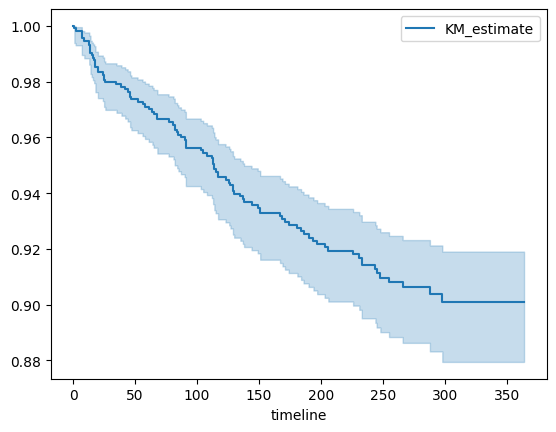

In [5]:
kaplan = KaplanMeierFitter()
kaplan.fit(data['time'], event_observed=data['event'])
kaplan.plot_survival_function()
plt.show()

![image.png](attachment:d2c20fb0-9729-4fb0-8836-3225a5fe0e4b.png)

1.2 Stratified Analysis

Plot separate Kaplan-Meier curves for patients in different treatment groups (use 'tx' column where 0=control, 1=treatment). Perform a log-rank test to compare the survival distributions.

Missing values in time: 0
Missing values in event: 0
Missing values in tx: 0


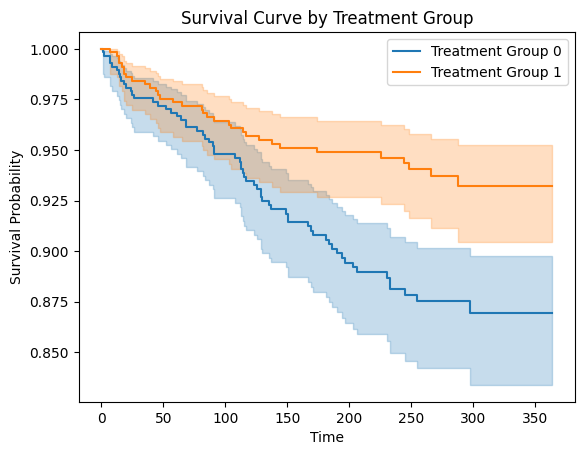

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.54 <0.005      9.75



The survival distributions are different


In [13]:
# First ensure all columns have the correct data types
data['time'] = pd.to_numeric(data['time'])
data['event'] = data['event'].astype(bool)  # Convert to boolean if not already
data['tx'] = data['tx'].astype(int)  # Ensure treatment is integer

# Check for missing values
print("Missing values in time:", data['time'].isna().sum())
print("Missing values in event:", data['event'].isna().sum())
print("Missing values in tx:", data['tx'].isna().sum())

# Remove rows with missing values if any exist
data = data.dropna(subset=['time', 'event', 'tx'])

# Now plot the curve
grouped = data.groupby('tx')
for name, group in grouped:
    kmf = KaplanMeierFitter()
    kmf.fit(group['time'], event_observed=group['event'])
    kmf.plot_survival_function(label=f'Treatment Group {name}')

plt.title('Survival Curve by Treatment Group')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# Log-rank test
# USE logrank_test
group1 = data[data['tx'] == 0]['time']
group2 = data[data['tx'] == 1]['time']
result = logrank_test(group1, group2, data[data['tx'] == 0]['event'], data[data['tx'] == 1]['event'])
display(result)

print('\n')
if result.p_value < 0.05:
    print("The survival distributions are different")
else:
    print("There is no difference in survival distributions")

![image.png](attachment:ada8c75e-c840-49c2-9e80-67280c2468bf.png)

![image.png](attachment:fd4eae88-577c-499c-b2c8-bd2e48baf368.png)

# Task 2: Cox Proportional Hazards Model

2.1 Fit Cox Model

Fit a Cox proportional hazards model using these covariates: ['age', 'cd4', 'karnof', 'priorzdv', 'tx']. Interpret the coefficients.

In [67]:
# USE CoxPHFitter & cph.print_summary
cph = CoxPHFitter()

cph.fit(data[ ['age', 'cd4', 'karnof', 'priorzdv', 'tx', 'time', 'event']], duration_col='time', event_col='event')
cph.print_summary()

# Interpretation:
# - Positive coefficients increase hazard (worse survival)
# - Negative coefficients decrease hazard (better survival)
# - exp(coef) is the hazard ratio
# Example interpretation for 'cd4':
# For each unit increase in CD4 count, the hazard of progression decreases by X%

<lifelines.CoxPHFitter: fitted with 1151 total observations, 1055 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 1151
number of events observed = 96
   partial log-likelihood = -608.90
         time fit was run = 2025-06-04 11:07:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.02      1.02      0.01           -0.00            0.04                1.00                1.05
cd4       -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
karnof    -0.05      0.95      0.01           -0.08           -0.03                0.93                0.97
priorzdv  -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
tx        -0.66      0.52      0.22           -1.08           -0.24                0.34                0.79

           cmp to     z      p  -log2(p)
covariate                               
age          0.00  1.93   0.05      4.22
cd4          0.00 -5.76 <0.005     26.84
karnof       0.00 -4.52 <0.005     17.33
priorzdv     0.00 -0.10   0.92      0.11
tx           0.00 -3.07 <0.005      8.88
---
Concordance = 0.78
Partial AIC = 1227.80
log-likelihood ratio test = 99.08 on 5 df
-log2(p) of ll-ratio test = 63.39

Значимые признаки: cd4, karnof, tx.    
Признак age на грани p=0.05

![image.png](attachment:a5871415-7278-488b-8236-59a0fea31ab3.png)

2.2 Partial Effects

Plot the partial effects of 'cd4' (CD4 count) on survival probability.

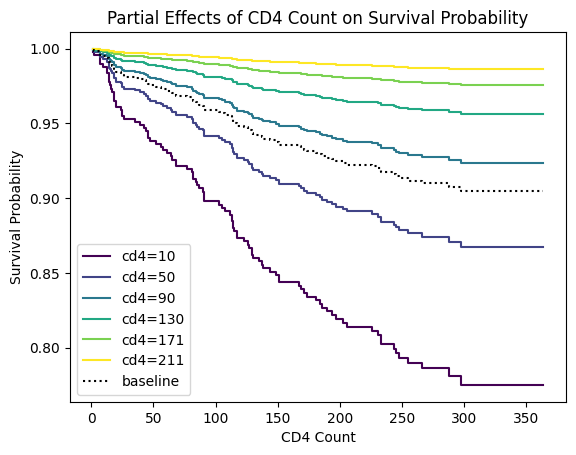

In [68]:
# Generate sensible values for cd4
cd4_values = np.linspace(
    max(data['cd4'].quantile(0.05), 10),  # Ensures minimum of 10 cells/mm³
    data['cd4'].quantile(0.95),
    6
).astype(int)

# Create the partial effects plot
# USE cph.plot_partial_effects_on_outcome
cph.plot_partial_effects_on_outcome(
    'cd4',
    cd4_values,
    cmap='viridis',
)
plt.xlabel('CD4 Count')
plt.ylabel('Survival Probability')
plt.title('Partial Effects of CD4 Count on Survival Probability')
plt.show()

![image.png](attachment:ab07918b-68b8-48d5-bbc6-bad479ef30d5.png)

# Task 3: Random Survival Forest

3.1 RSF Model

Fit RSF Model and Predict Survival Functions

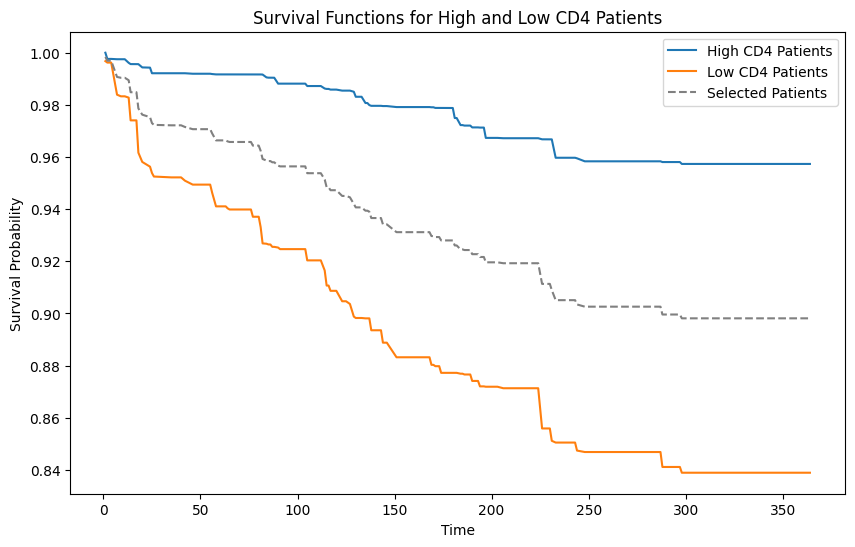

In [69]:
# Prepare data
y = Surv.from_arrays(data['event'], data['time'])
X = data.drop(['time', 'event'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X[ ['age', 'cd4', 'karnof', 'priorzdv', 'tx']], y, test_size=0.25, random_state=42)

# Fit model
# USE RandomSurvivalForest

rsf = RandomSurvivalForest(n_estimators=1000, min_samples_split=6, random_state=42)
rsf.fit(X_train, y_train)

# Select high and low CD4 count patients for comparison
X_test_high = X_test[X_test['cd4'] > X_test['cd4'].median()].sample(10, random_state=42)
X_test_low = X_test[X_test['cd4'] <= X_test['cd4'].median()].sample(10, random_state=42)
X_test_sel = pd.concat([X_test_high, X_test_low])

# Predict survival functions
# USE rsf.predict_survival_function
pred_high = rsf.predict_survival_function(X_test_high, return_array=True).mean(axis=0)
pred_low = rsf.predict_survival_function(X_test_low, return_array=True).mean(axis=0)

pred = rsf.predict_survival_function(X_test_sel, return_array=True).mean(axis=0)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(rsf.unique_times_, pred_high, label='High CD4 Patients')
ax.plot(rsf.unique_times_, pred_low, label='Low CD4 Patients')
ax.plot(rsf.unique_times_, pred, label='Selected Patients', color='grey', linestyle='--')

ax.set_xlabel('Time')
ax.set_ylabel('Survival Probability')
ax.set_title('Survival Functions for High and Low CD4 Patients')
plt.legend()
plt.show()


![image.png](attachment:4e39c587-dcb8-49a1-a5eb-42de7d4903c0.png)

3.2 Feature Importance Analysis

In [70]:
# USE permutation_importance
results = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)

In [71]:
pd.DataFrame(
    {
        k: results[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
cd4,0.200911,0.044622
age,0.024983,0.015373
tx,0.016888,0.024452
karnof,0.014779,0.014946
priorzdv,0.005246,0.013763


![image.png](attachment:3c1064d9-8d97-4e01-8ab5-3549930b3cbd.png)

# Task 4: XGBoost AFT Model

4.1 Fit AFT Model

Fit an Accelerated Failure Time (AFT) model using XGBoost with the same covariates as the Cox model.

In [53]:
# Prepare data for XGBoost AFT
dtrain = xgb.DMatrix(X_train[['age', 'cd4', 'karnof', 'priorzdv', 'tx']],
                     enable_categorical=True)
dtrain.set_float_info('label_lower_bound', y_train['time'])
dtrain.set_float_info('label_upper_bound', np.where(
    y_train['event'], y_train['time'], np.inf))

dtest = xgb.DMatrix(X_test[['age', 'cd4', 'karnof', 'priorzdv', 'tx']],
                    enable_categorical=True)
dtest.set_float_info('label_lower_bound', y_test['time'])
dtest.set_float_info('label_upper_bound', np.where(
    y_test['event'], y_test['time'], np.inf))

# Parameters
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'tree_method': 'hist',
    'learning_rate': 0.05,
    'max_depth': 5,
    'seed': 42,
}

# Train model
# USE xgb.train with evals=[(dtrain, 'train'), (dtest, 'test')]
bst = xgb.train(params, dtrain, num_boost_round=100,
                evals=[(dtrain, 'train'), (dtest, 'test')],
                early_stopping_rounds=10)

[0]	train-aft-nloglik:19.18566	test-aft-nloglik:19.21474
[1]	train-aft-nloglik:17.49455	test-aft-nloglik:17.52349
[2]	train-aft-nloglik:15.96407	test-aft-nloglik:15.99654
[3]	train-aft-nloglik:14.57862	test-aft-nloglik:14.61572
[4]	train-aft-nloglik:13.32411	test-aft-nloglik:13.36201
[5]	train-aft-nloglik:12.18788	test-aft-nloglik:12.23016
[6]	train-aft-nloglik:11.15849	test-aft-nloglik:11.20203
[7]	train-aft-nloglik:10.22540	test-aft-nloglik:10.27643
[8]	train-aft-nloglik:9.37950	test-aft-nloglik:9.43755
[9]	train-aft-nloglik:8.61249	test-aft-nloglik:8.67350
[10]	train-aft-nloglik:7.91655	test-aft-nloglik:7.98387
[11]	train-aft-nloglik:7.28510	test-aft-nloglik:7.35512
[12]	train-aft-nloglik:6.71170	test-aft-nloglik:6.78690
[13]	train-aft-nloglik:6.19094	test-aft-nloglik:6.27107
[14]	train-aft-nloglik:5.71793	test-aft-nloglik:5.80047
[15]	train-aft-nloglik:5.28734	test-aft-nloglik:5.37526
[16]	train-aft-nloglik:4.89563	test-aft-nloglik:4.98863
[17]	train-aft-nloglik:4.53817	test-aft-nl

Plot feature importance from the XGBoost model.

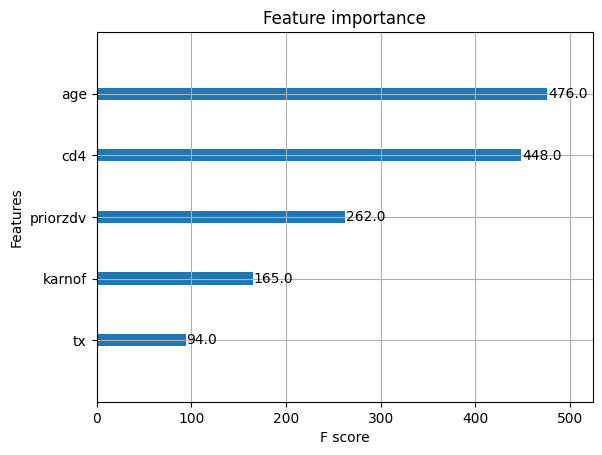

In [54]:
# USE xgb.plot_importance
xgb.plot_importance(bst)
plt.show()

![image.png](attachment:51fb0757-6fc7-4bf4-bb46-e8f11240bf74.png)

# Task 5: Model Comparison

Compare the performance of the RSF, and XGBoost AFT models using concordance index.

In [ ]:
# Be carefull, all models default outputs are different (partial_hazards, expected survival time, risk_scores)
# But we still compare performance without additional transformations of predicts
# Cause we compare not absolute values, but rankings

In [73]:
from sksurv.metrics import concordance_index_censored

# Cox model predictions
cph_pred = cph.predict_partial_hazard(X_test)

# RSF predictions
rsf_pred = rsf.predict(X_test)

# XGBoost predictions
xgb_pred = bst.predict(dtest)

# Calculate C-index
# USE concordance_index_censored
# change sign of prediction for xgb_pred, greater time means smaller risk
cph_cindex = concordance_index_censored(y_test['event'], y_test['time'], cph_pred)[0]
rsf_cindex = concordance_index_censored(y_test['event'], y_test['time'], rsf_pred)[0]
xgb_cindex = concordance_index_censored(y_test['event'], y_test['time'], -xgb_pred)[0]

print(f"Cox PH C-index: {cph_cindex:.3f}")
print(f"RSF C-index: {rsf_cindex:.3f}")
print(f"XGBoost AFT C-index: {xgb_cindex:.3f}")

Cox PH C-index: 0.790
RSF C-index: 0.752
XGBoost AFT C-index: 0.712


Cox PH C-index: 0.790

RSF C-index: 0.762

XGBoost AFT C-index: 0.753